In [10]:
###settings used thoughout the entire notebook:
import pandas

pfam_names_and_descriptions_filename="pfamID_to_name_desc_longdesc.tsv"
annotation_categories_we_care_about=["y","s","e","m"]





pfam_id_name_description_df=pandas.read_table(pfam_names_and_descriptions_filename,index_col=0,dtype="str",keep_default_na=False, na_values=[])

#grabbing domains we care about from the descriptions file
domains_we_care_about=pfam_id_name_description_df[pfam_id_name_description_df["enzyme_annotation"].isin(annotation_categories_we_care_about)].index.to_list()


# loading domains from a file
# domains_we_care_about_filename="enzymatic_domains.txt"
# with open(domains_we_care_about_filename,'r') as file:
#     domains_we_care_about=file.read().splitlines()


# if you wanted to look at ALL pfam domains (works for analyzing PfamScan output but probably won't work for all-of-uniprot analysis)
# domains_we_care_about=["PF{:05d}".format(i) for i in range(20000)]

In [11]:
###some setup we need for this notebook in general
import itertools
import collections
import networkx
import json
import re

###define some functions
       
def load_PfamScan_results_dataframe(input_filename,verbose=True):
    if(verbose):
        print("loading "+input_filename)
    pfamscan_results_df=pandas.read_table(input_filename,
                                          delim_whitespace=True,
#                                           dtype="str",
                                          comment="#",
                                          header=None,
                                          usecols=[0,5,7,12,14],
                                          names=["protein_id","pfam_accession","type","evalue","clan"])

    #get rid of the version part of the pfam accession
    pfamscan_results_df["pfam_accession"]=pfamscan_results_df["pfam_accession"].str.split(".").str[0]
    
    return pfamscan_results_df



def keep_only_lowest_evalue_per_clan(dataframe,verbose=True):
    """
    pfam_scan removes domains in the same clan that are overlapping, but sometimes it doesn't detect the
    overlap quite right. Since we mostly care about the co-ocurrence of domains that are quite different,
    we just throw out all domains in the same clan in the same protein, whether they overlap or not.
    this function takes care of that.
    """
    list_of_indexes_we_want_to_keep=[]
    counter=0
    grouped_df=dataframe.groupby("protein_id")
    if (verbose):
        print("filtering for best hit per clan ")
        total_groups=len(grouped_df)
        count=0
    for protein_id,protein_grouped_df, in grouped_df:
        if (verbose):
            if(count%1000==0 and count>0):
                print("now processing protein #{} out of {}".format(count,total_groups))
            count+=1
        for clan,clan_grouped_df in protein_grouped_df.groupby("clan"):
            if(clan=="No_clan"):
                list_of_indexes_we_want_to_keep+=clan_grouped_df.index.to_list()
            else:
                list_of_indexes_we_want_to_keep.append(clan_grouped_df["evalue"].idxmin())
    return dataframe.loc[list_of_indexes_we_want_to_keep]



def load_PfanScan_results_only_domains_we_care_about_dataframe(input_filename,verbose=True):
    pfamscan_results_df=load_PfamScan_results_dataframe(input_filename,verbose)
    if (verbose):
        print("filtering for domains we care about")
    pfamscan_results_with_domains_we_care_about=pfamscan_results_df[pfamscan_results_df["pfam_accession"].isin(domains_we_care_about)]
    return keep_only_lowest_evalue_per_clan(pfamscan_results_with_domains_we_care_about,verbose)



def load_PfamScan_domain_pairs_we_care_about(input_filename,verbose=True):
    filtered_pfamscan_results_df=load_PfanScan_results_only_domains_we_care_about_dataframe(input_filename,verbose)
    domain_to_protein_list_dict=collections.defaultdict(list)
    domain_pair_to_protein_list_dict=collections.defaultdict(list)
    grouped_df=filtered_pfamscan_results_df.groupby("protein_id")
    for protein_id, data_series in grouped_df:
        domain_entries=frozenset(data_series["pfam_accession"]) 
        for entry in domain_entries:
            domain_to_protein_list_dict[entry].append(protein_id)
        for combination in itertools.combinations(domain_entries,r=2):
            domain_pair_to_protein_list_dict[frozenset(combination)].append(protein_id)
    return domain_to_protein_list_dict,domain_pair_to_protein_list_dict

print("Completed")



#to use this function, the dataframe needs a "Cross-reference (Pfam)" column and the protein IDs need to be the index
def preprocess_domain_pairs_in_uniprot_dataframe(df,verbose=True):
    domain_mapping_list_dict=collections.defaultdict(list)
    domain_pair_frozenset_list_dict=collections.defaultdict(list)
    counter=0
    for protein_id,row in df.iterrows():
        if(counter%10000==0 and counter>0 and verbose):
            print("now processing row {} of {}".format(counter,len(df)))
        counter+=1
        pfams_string=row["Cross-reference (Pfam)"]
        entries=frozenset(pfams_string.split(";")[:-1]) #the "[:-1]" is to drop the last element, which is always empty because the strings end in ";"
        entries=entries.intersection(domains_we_care_about)
        for entry in entries:
            domain_mapping_list_dict[entry].append(protein_id)
        for combination in itertools.combinations(entries,r=2):
            domain_pair_frozenset_list_dict[frozenset(combination)].append(protein_id)
    return domain_mapping_list_dict,domain_pair_frozenset_list_dict

def test_simplestring(string):
    assert isinstance(string,str), "\"{}\" needs to be a string".format(string)
    assert re.match(r'^[A-Za-z0-9_-]+$', string), "\"{}\" may only contain alphanumeric characters, dash and underscore".format(string)

class DomainOccurrences:
    def __init__(self, name_string, domain_to_protein_list_dict, domain_pair_frozenset_to_protein_list_dict):
        assert isinstance(domain_to_protein_list_dict,dict), "domain_to_protein_list_dict needs to be a dict"
        assert isinstance(domain_pair_frozenset_to_protein_list_dict,dict), "domain_pair_frozenset_to_protein_list_dict needs to be a dict"
        test_simplestring(name_string)
        #make sure that all domains that have pairs are also in the single-domain dict
        for domain in domain_to_protein_list_dict:
            test_simplestring(domain)
        for domain_pair in domain_pair_frozenset_to_protein_list_dict:
            for domain in domain_pair:
                test_simplestring(domain)
                assert domain in domain_to_protein_list_dict, "domain {} not found in domain_to_protein_list_dict".format(domain)
        
        self.domain_to_protein_list_dict=dict(domain_to_protein_list_dict)#!
        self.domain_pair_frozenset_to_protein_list_dict=dict(domain_pair_frozenset_to_protein_list_dict)#!
        self.name=name_string
    
    def get_domain_protein_list(self,entry):
        if entry in self.domain_to_protein_list_dict:
            return list(self.domain_to_protein_list_dict[entry])
        else:
            return []
    
    def get_domain_protein_tally(self,entry):
        if entry in self.domain_to_protein_list_dict:
            return len(self.domain_to_protein_list_dict[entry])
        else:
            return 0

    def get_domain_pair_protein_list(self,entries_frozenset):
        if entries_frozenset in self.domain_pair_frozenset_to_protein_list_dict:
            return list(self.domain_pair_frozenset_to_protein_list_dict[entries_frozenset])
        else:
            return []
        
    def get_domain_pair_protein_tally(self,entries_frozenset):
        if entries_frozenset in self.domain_pair_frozenset_to_protein_list_dict:
            return len(self.domain_pair_frozenset_to_protein_list_dict[entries_frozenset])
        else:
            return 0

    def generate_coocurrence_network(self,
                                     output_filename,
                                     *secondary_domaincooccurrences, #zero or more
                                     generate_directed_graph=True,
                                     draw_node_when=lambda occurrence: occurrence>=1,
                                     draw_edge_when=lambda absolute_coocurrence,pct_coocurrence: absolute_coocurrence>=1, #pct_cooccurrence is always at 100 for generate_directed_graph=True
                                     max_entries_in_list=100,
                                     verbose=True):

        truncate_list=lambda input_list: input_list if len(input_list)<=max_entries_in_list else ["Too many entries, only showing "+str(max_entries_in_list)+" (pass a max_entries_in_list argument to change this)"]+input_list[0:max_entries_in_list-1]

        def generate_edge_properties(accessions_list,entries_frozenset):
            cooccurring_domains_in_mibig_protein_list=mibig_domainoccurrences.get_domain_pair_protein_list(entries_frozenset)
            cooccurring_domains_in_mibig_protein_list_with_accessions=[k+":"+v for k,v in uniprot_to_mibig_mapping_df.loc[cooccurring_domains_in_mibig_protein_list,"mibig_accession"].iteritems()]
            cooccurring_domains_in_uniprot_curated_catalytic_list=uniprot_curated_catalytic_domainoccurrences.get_domain_pair_protein_list(entries_frozenset)
            cooccurring_domains_in_uniprot_curated_catalytic_list_with_rhea_ids=[k+":"+v for k,v in uniprot_curated_catalytic_df.loc[cooccurring_domains_in_uniprot_curated_catalytic_list,"Rhea Ids"].iteritems()]
            cooccurring_domains_in_brenda_list=brenda_domainoccurrences.get_domain_pair_protein_list(entries_frozenset)
            cooccurring_domains_in_brenda_list_with_accessions=[k+":"+v for k,v in uniprot_to_brenda_mapping_df.loc[cooccurring_domains_in_brenda_list,"brenda_ec_number"].iteritems()]
            tally=len(accessions_list)

            in_databases_abbreviation_list=[]
            in_databases_superscript_abbreviation_list=[]
            if len(cooccurring_domains_in_uniprot_curated_catalytic_list)>0:
                in_databases_abbreviation_list.append("U")
                in_databases_superscript_abbreviation_list.append("ᵁ")
            if len(cooccurring_domains_in_mibig_protein_list)>0:
                in_databases_abbreviation_list.append("M")
                in_databases_superscript_abbreviation_list.append("ᴹ")
            if len(cooccurring_domains_in_brenda_list)>0:
                in_databases_abbreviation_list.append("B")
                in_databases_superscript_abbreviation_list.append("ᴮ")

            edge_properties_dict={
                "cooccurrences_list":truncate_list(accessions_list),
                "cooccurrences_count":tally,

                "cooccurring_domains_in_uniprot_curated_catalytic_list":truncate_list(cooccurring_domains_in_uniprot_curated_catalytic_list),
                "cooccurring_domains_in_uniprot_curated_catalytic_list_with_rhea_ids":truncate_list(cooccurring_domains_in_uniprot_curated_catalytic_list_with_rhea_ids),
                "cooccurring_domains_in_uniprot_curated_catalytic_count":len(cooccurring_domains_in_uniprot_curated_catalytic_list),
                "cooccurring_domains_in_uniprot_curated_catalytic_boolean":len(cooccurring_domains_in_uniprot_curated_catalytic_list)>0,

                "cooccurring_domains_in_mibig_protein_list":truncate_list(cooccurring_domains_in_mibig_protein_list),
                "cooccurring_domains_in_mibig_protein_list_with_mibig_accessions":truncate_list(cooccurring_domains_in_mibig_protein_list_with_accessions),
                "cooccurring_domains_in_mibig_protein_count":len(cooccurring_domains_in_mibig_protein_list),
                "cooccurring_domains_in_mibig_protein_boolean":len(cooccurring_domains_in_mibig_protein_list)>0,

                "cooccurring_domains_in_brenda_list":truncate_list(cooccurring_domains_in_brenda_list),
                "cooccurring_domains_in_brenda_list_with_ec_numbers":truncate_list(cooccurring_domains_in_brenda_list_with_accessions),
                "cooccurring_domains_in_brenda_count":len(cooccurring_domains_in_brenda_list),
                "cooccurring_domains_in_brenda_boolean":len(cooccurring_domains_in_brenda_list)>0,

                "cooccurring_domains_in_databases_abbreviations":"".join(in_databases_abbreviation_list),
                "cooccurring_domains_in_databases_abbreviation_list":in_databases_abbreviation_list,

                "human_readable_string_a":str(tally),
                "human_readable_string_b":str(tally)+(" proteins" if tally>1 else " protein"),
                "human_readable_string_c":str(tally)+" "+"".join(["("+x+")" for x in in_databases_abbreviation_list]),
                "human_readable_string_d":str(tally)+" ("+"".join(in_databases_abbreviation_list)+")",
                "human_readable_string_e":str(tally)+(" proteins" if tally>1 else " protein")+"\n"+"".join(["("+x+")" for x in in_databases_abbreviation_list]),
                "human_readable_string_f":str(tally)+"".join(in_databases_superscript_abbreviation_list),
                "human_readable_string_g":str(tally)+("⁽"+"".join(in_databases_superscript_abbreviation_list)+"⁾" if len(in_databases_superscript_abbreviation_list)>0 else ""),
                "human_readable_string_h":str(tally)+" "+"".join(["⁽"+x+"⁾" for x in in_databases_superscript_abbreviation_list]),
                "human_readable_string_i":str(tally),
                "human_readable_string_j":str(tally)+(" proteins" if tally>1 else " protein"),
            }
            
            for domainoccurrence in secondary_domaincooccurrences:
                domainoccurrence_list=domainoccurrence.get_domain_pair_protein_list(entries_frozenset) #!
                domainoccurrence_len=len(domainoccurrence_list)
                edge_properties_dict["cooccurring_domains_in_"+domainoccurrence.name+"_list"]=truncate_list(domainoccurrence_list)
                edge_properties_dict["cooccurring_domains_in_"+domainoccurrence.name+"_count"]=domainoccurrence_len
                edge_properties_dict["cooccurring_domains_in_"+domainoccurrence.name+"_boolean"]=domainoccurrence_len>0
                edge_properties_dict["human_readable_string_i"]+=" ("+str(domainoccurrence_len)+")"
                edge_properties_dict["human_readable_string_j"]+=",\n"+str(domainoccurrence_len)+" in "+domainoccurrence.name
                                     
            
            
            return edge_properties_dict


        #start of the meat of the function
        coocurrence_network=networkx.DiGraph() if generate_directed_graph else networkx.Graph()

        
        #draw nodes
        if verbose:
            print("drawing nodes...")
        for domain_accession in self.domain_to_protein_list_dict:
            domain_tally=self.get_domain_protein_tally(domain_accession)
            if(draw_node_when(domain_tally)):
                name_string=pfam_id_name_description_df["Name"].get(domain_accession, default="unknown_name")

                domain_in_mibig_list=mibig_domainoccurrences.get_domain_protein_list(domain_accession)
                domain_in_uniprot_curated_catalytic_list=uniprot_curated_catalytic_domainoccurrences.get_domain_protein_list(domain_accession)
                domain_in_brenda_list=brenda_domainoccurrences.get_domain_protein_list(domain_accession)
                domain_in_mibig_list_with_accessions=[k+":"+v for k,v in uniprot_to_mibig_mapping_df.loc[domain_in_mibig_list,"mibig_accession"].iteritems()]
                domain_in_brenda_list_with_accessions=[k+":"+v for k,v in uniprot_to_brenda_mapping_df.loc[domain_in_brenda_list,"brenda_ec_number"].iteritems()]
                domain_in_uniprot_curated_catalytic_list_with_rhea_ids=[k+":"+v for k,v in uniprot_curated_catalytic_df.loc[domain_in_uniprot_curated_catalytic_list,"Rhea Ids"].iteritems()]


                in_databases_abbreviation_list=[]
                if len(domain_in_uniprot_curated_catalytic_list)>0:
                    in_databases_abbreviation_list.append("U")
                if len(domain_in_mibig_list)>0:
                    in_databases_abbreviation_list.append("M")
                if len(domain_in_brenda_list)>0:
                    in_databases_abbreviation_list.append("B")




                node_properties_dict={
                        "name":name_string,
                        "description":pfam_id_name_description_df["Description"].get(domain_accession, default="unknown_description"),
                        "long_description":pfam_id_name_description_df["Long_description"].get(domain_accession, default="unknown_long_description"),
                        "annotation":pfam_id_name_description_df["enzyme_annotation"].get(domain_accession, default="unknown_annotation"),
                        "occurrences_count":domain_tally,

                        "human_readable_string_1":name_string,
                        "human_readable_string_2":name_string+"\n("+str(domain_tally)+(" proteins)" if domain_tally>1 else " protein)"),
                        "human_readable_string_3":name_string+"\n"+str(domain_tally)+(" proteins" if domain_tally>1 else " protein"),
                        "human_readable_string_4":name_string+"\n("+str(domain_tally)+")",

                        "domain_in_uniprot_curated_catalytic_list":truncate_list(domain_in_uniprot_curated_catalytic_list),
                        "domain_in_uniprot_curated_catalytic_count":len(domain_in_uniprot_curated_catalytic_list),
                        "domain_in_uniprot_curated_catalytic_boolean":len(domain_in_uniprot_curated_catalytic_list)>0,

                        "domain_in_mibig_list":truncate_list(domain_in_mibig_list),
                        "domain_in_mibig_count":len(domain_in_mibig_list),
                        "domain_in_mibig_boolean":len(domain_in_mibig_list)>0,

                        "in_databases_abbreviations":"".join(in_databases_abbreviation_list),
                        }

                for domainoccurrence in secondary_domaincooccurrences:
                    domainoccurrence_list=domainoccurrence.get_domain_protein_list(domain_accession) #!
                    domainoccurrence_len=len(domainoccurrence_list)
                    assert "occurrence_in_"+domainoccurrence.name+"_list" not in node_properties_dict, "cannot use duplicate names for secondary DomainOccurrences"
                    node_properties_dict["occurrence_in_"+domainoccurrence.name+"_list"]=truncate_list(domainoccurrence_list)
                    node_properties_dict["occurrence_in_"+domainoccurrence.name+"_count"]=domainoccurrence_len
                    node_properties_dict["occurrence_in_"+domainoccurrence.name+"_boolean"]=domainoccurrence_len>0
                    node_properties_dict["human_readable_string_3"]+=",\n"+str(domainoccurrence_len)+" in "+domainoccurrence.name
                    node_properties_dict["human_readable_string_4"]+=" ("+str(domainoccurrence_len)+")"
                            
                            
                coocurrence_network.add_node(domain_accession,**node_properties_dict)

        #draw edges

        if verbose:
            print("drawing edges...")

        if generate_directed_graph: #draw directed edges
            count=0
            for entry in self.domain_to_protein_list_dict:
                if(count%500==0 and count>0 and verbose):
                    print("drawing edges from node # {} out of {}".format(count,len(self.domain_to_protein_list_dict)))
                count+=1
                domain_tally=self.get_domain_protein_tally(entry)
                for other_entry in self.domain_to_protein_list_dict:
                    if entry!=other_entry:
                        entries_frozenset=frozenset([entry,other_entry])
                        accessions_list=self.get_domain_pair_protein_list(entries_frozenset) #!
                        tally=len(accessions_list)
                        percent_coocurrence=round(tally/domain_tally*100,5)
                        if draw_edge_when(tally,percent_coocurrence):

                            edge_properties_dict=generate_edge_properties(accessions_list,entries_frozenset)
                            in_databases_abbreviation_list=edge_properties_dict["cooccurring_domains_in_databases_abbreviation_list"]
                            edge_properties_dict["percent_cooccurrence"]=percent_coocurrence
                            edge_properties_dict["human_readable_string_1"]=str(tally)+"/"+str(domain_tally)+"\n("+str(round(tally/domain_tally*100,2))+"%)"
                            edge_properties_dict["human_readable_string_2"]=str(tally)+"/"+str(domain_tally)
                            edge_properties_dict["human_readable_string_3"]=str(tally)+"/"+str(domain_tally)+"\n("+str(round(tally/domain_tally*100,2))+"%) "+"".join(["("+x+")" for x in in_databases_abbreviation_list])
                            edge_properties_dict["human_readable_string_4"]=str(tally)+"/"+str(domain_tally)+" ("+str(int(round(tally/domain_tally*100,0)))+"%)\n"+"".join(["("+x+")" for x in in_databases_abbreviation_list])
                            edge_properties_dict["human_readable_string_5"]=str(tally)+"/"+str(domain_tally)+" ("+str(round(tally/domain_tally*100,2))+"%)"
                            edge_properties_dict["human_readable_string_6"]=str(tally)+"/"+str(domain_tally)+" ("+str(round(tally/domain_tally*100,2))+"%)"
                            edge_properties_dict["human_readable_string_7"]=str(tally)+" ("+str(round(tally/domain_tally*100,2))+"%)"
                            
                            if len(secondary_domaincooccurrences)>0:
                                edge_properties_dict["human_readable_string_6"]+=" in "+self.name
                            
                            for domainoccurrence in secondary_domaincooccurrences:
                                domainoccurrence_list=domainoccurrence.get_domain_pair_protein_list(entries_frozenset)
                                domainoccurrence_len=len(domainoccurrence_list)
                                secondary_from_tally=domainoccurrence.get_domain_protein_tally(entry) #!
                                if secondary_from_tally>0:
                                    secondary_percent_cooccurrence=round(domainoccurrence_len/secondary_from_tally*100,5)
                                    edge_properties_dict["percent_cooccurrence_in_"+domainoccurrence.name]=secondary_percent_cooccurrence
                                    edge_properties_dict["human_readable_string_5"]+=",\n"+str(domainoccurrence_len)+"/"+str(secondary_from_tally)+" ("+str(round(secondary_percent_cooccurrence,2))+"%)"
                                    edge_properties_dict["human_readable_string_6"]+=",\n"+str(domainoccurrence_len)+"/"+str(secondary_from_tally)+" ("+str(round(secondary_percent_cooccurrence,2))+"%)"+" in "+domainoccurrence.name
                                    edge_properties_dict["human_readable_string_7"]+=",\n"+str(domainoccurrence_len)+" ("+str(round(secondary_percent_cooccurrence,2))+"%)"
                                else:
                                    edge_properties_dict["percent_cooccurrence_in_"+domainoccurrence.name]="N/A"
                                    edge_properties_dict["human_readable_string_5"]+=",\n"+str(domainoccurrence_len)+"/"+str(secondary_from_tally)
                                    edge_properties_dict["human_readable_string_6"]+=",\n"+str(domainoccurrence_len)+"/"+str(secondary_from_tally)+" in "+domainoccurrence.name
                                    edge_properties_dict["human_readable_string_7"]+=",\n"+str(domainoccurrence_len)

                            
                            coocurrence_network.add_edge(entry,other_entry, **edge_properties_dict)

        else: #draw undirected edges
            count=0
            for domain_pair_frozenset, accessions_set in self.domain_pair_frozenset_to_protein_list_dict.items():
                if(count%1000==0 and count>0 and verbose):
                    print("drawing edge # {} out of {}".format(count,len(domain_pair_to_protein_list_dict)))
                tally=len(accessions_set)
                if draw_edge_when(tally,100.0):
                    edge_properties_dict=generate_edge_properties(list(accessions_set),domain_pair_frozenset)
                    coocurrence_network.add_edge(*domain_pair_frozenset, **edge_properties_dict)



        if verbose:
            print("writing file "+output_filename+"...")
        with open(output_filename, 'w') as out_file:
            json.dump(networkx.cytoscape_data(coocurrence_network), out_file)
        if verbose:
            print("completed writing file")
    


Completed


# Calculating percentage of multi-domain enzymes in various species (Fig. 1a)
You ought to fill in your own e-mail address and api-key for NCBI:

In [1]:
email_for_ncbi="your@email.com"
ncbi_api_key="get_this_from_your_NCBI_account"

In [3]:
import requests
import time

###general settings and filenames for this section
mibig_to_ncbi_mapping_filename="ncbi_accessions_to_mibig.tsv" #we generated this file in the preparing_data notebook


#tuples of species and the taxid with which the BGCs are annotated in MIBiG
species_of_interest=[("Scoelicolor_A32",100226),
                     ("Stropica_CNB-440",369723),
                     ("Pfluorescens_Pf5",220664)]





mibig_to_ncbi_mapping_df=pandas.read_table(mibig_to_ncbi_mapping_filename)
session = requests.Session()
session.headers.update({'User-Agent': 'programmatic access by '+email_for_ncbi,
                       'From':email_for_ncbi,
                       })
ncbi_efetch_base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?api_key="+ncbi_api_key+"&email="+email_for_ncbi+"&db=protein&rettype=fasta&id="

for species_name,taxid in species_of_interest:
    
    output_filename="{}_taxid_{}_entries_in_mibig_only.faa".format(species_name,taxid)
    
    ids_frozenset=frozenset(mibig_to_ncbi_mapping_df[mibig_to_ncbi_mapping_df["mibig_taxid"]==taxid]["ncbi_protein_accession"].to_list())
    request_url=ncbi_efetch_base_url+",".join(ids_frozenset)
    print("requesting {} proteins for {}".format(len(ids_frozenset),species_name))
    r=session.get(request_url)
    if(r.ok):
        print("response in "+str(r.elapsed.total_seconds())+" s")
        if(r.text):
            with open(output_filename,"wt") as file:
                file.write(r.text)
            print("file {} written".format(output_filename))
        else:
            print("no results")
    else:
        print("error: "+str(r.status_code))
    time.sleep(5)

print("Completed")

requesting 194 proteins for Scoelicolor_A32
response in 1.015055 s
file Scoelicolor_A32_taxid_100226_entries_in_mibig_only.faa written
requesting 182 proteins for Stropica_CNB-440
response in 0.540926 s
file Stropica_CNB-440_taxid_369723_entries_in_mibig_only.faa written
requesting 144 proteins for Pfluorescens_Pf5
response in 0.639825 s
file Pfluorescens_Pf5_taxid_220664_entries_in_mibig_only.faa written
Completed


now we run these files through pfam_scan.pl, as well as the full proteomes for these same organisms.

In [ ]:
%%bash
export PERL5LIB=/mnt/d/domain_analysis/PfamScan:$PERL5LIB #change to wherever you have installed PfamScan
#mibig-only files
./PfamScan/pfam_scan.pl -fasta Scoelicolor_A32_taxid_100226_entries_in_mibig_only.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Scoelicolor_A32_entries_in_mibig_only.PfamScan -cpu 7 &
./PfamScan/pfam_scan.pl -fasta Stropica_CNB-440_taxid_369723_entries_in_mibig_only.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Stropica_CNB-440_entries_in_mibig_only.PfamScan -cpu 7
./PfamScan/pfam_scan.pl -fasta Pfluorescens_Pf5_taxid_220664_entries_in_mibig_only.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Pfluorescens_Pf5_entries_in_mibig_only.PfamScan -cpu 7
#full proteomes (got these files from genbank)
./PfamScan/pfam_scan.pl -fasta GCA_000203835.1_ASM20383v1_protein.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Scoelicolor_A32-protein.fasta -cpu 7 &
./PfamScan/pfam_scan.pl -fasta GCA_000016425.1_ASM1642v1_protein.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Stropica_CNB-440.PfamScan -cpu 7 &
./PfamScan/pfam_scan.pl -fasta GCA_000012265.1_ASM1226v1_protein.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Pfluorescens_Pf5.PfamScan -cpu 7 &


In [12]:
files_to_analyze=["Scoelicolor_A32.PfamScan",
                  "Scoelicolor_A32_entries_in_mibig_only.PfamScan",
                  "Stropica_CNB-440.PfamScan",
                  "Stropica_CNB-440_entries_in_mibig_only.PfamScan",
                  "Pfluorescens_Pf5.PfamScan",
                  "Pfluorescens_Pf5_entries_in_mibig_only.PfamScan"]






multidomain_series=pandas.Series(index=files_to_analyze,dtype='float')
domain_count_df=pandas.DataFrame(columns=files_to_analyze)
for filename in files_to_analyze:
    print("analyzing "+filename)
    filtered_results_df=load_PfanScan_results_only_domains_we_care_about_dataframe(filename)
    accession_to_number_of_domains_series=filtered_results_df["protein_id"].value_counts()
    proportion_multidomain=sum(accession_to_number_of_domains_series>1)/len(accession_to_number_of_domains_series)
    multidomain_series[filename]=proportion_multidomain
    domain_count_df[filename]=accession_to_number_of_domains_series.value_counts()
    
    
print("Completed.")
pandas.DataFrame(multidomain_series,columns=["proportion_multidomain"])

analyzing Scoelicolor_A32.PfamScan
loading Scoelicolor_A32.PfamScan
filtering for domains we care about
filtering for best hit per clan 
now processing protein #1000 out of 2938
now processing protein #2000 out of 2938
analyzing Scoelicolor_A32_entries_in_mibig_only.PfamScan
loading Scoelicolor_A32_entries_in_mibig_only.PfamScan
filtering for domains we care about
filtering for best hit per clan 
analyzing Stropica_CNB-440.PfamScan
loading Stropica_CNB-440.PfamScan
filtering for domains we care about
filtering for best hit per clan 
now processing protein #1000 out of 1844
analyzing Stropica_CNB-440_entries_in_mibig_only.PfamScan
loading Stropica_CNB-440_entries_in_mibig_only.PfamScan
filtering for domains we care about
filtering for best hit per clan 
analyzing Pfluorescens_Pf5.PfamScan
loading Pfluorescens_Pf5.PfamScan
filtering for domains we care about
filtering for best hit per clan 
now processing protein #1000 out of 2264
now processing protein #2000 out of 2264
analyzing Pfluor

,proportion_multidomain
Scoelicolor_A32.PfamScan,0.022124
Scoelicolor_A32_entries_in_mibig_only.PfamScan,0.100000
Stropica_CNB-440.PfamScan,0.033080
Stropica_CNB-440_entries_in_mibig_only.PfamScan,0.091837
Pfluorescens_Pf5.PfamScan,0.025618
Pfluorescens_Pf5_entries_in_mibig_only.PfamScan,0.161765


In [13]:
#if you wanted to see a more detailed distribution of the number of domains in enzymes...
domain_count_df.fillna(0).astype('int').sort_index()

,Scoelicolor_A32.PfamScan,Scoelicolor_A32_entries_in_mibig_only.PfamScan,Stropica_CNB-440.PfamScan,Stropica_CNB-440_entries_in_mibig_only.PfamScan,Pfluorescens_Pf5.PfamScan,Pfluorescens_Pf5_entries_in_mibig_only.PfamScan
1,2873,99,1783,89,2206,57
2,48,5,48,1,48,8
3,5,1,5,3,7,3
4,9,5,5,3,3,0
5,3,0,3,2,0,0


# Generate enzyme domain co-occurrence networks from PfamScan output (Fig. 1b-d)

In [14]:
###Here we pre-process the uniprot entries annotated in various databases for easy indexing in a dictionary

#General settings and filenames for this section.
#We generated these files in the preparing_data notebook.
uniprot_curated_catalytic_filename="Uniprot_curated_catalytic_activity.tsv"
uniprot_pathway_filename="uniprot_pathway_complete.tsv"
uniprot_to_mibig_mapping_filename="uniprot_to_mibig_merged_on_protein_id.tsv"
uniprot_to_brenda_mapping_filename="uniprot_to_brenda_merged.tsv"




uniprot_curated_catalytic_df=pandas.read_table(uniprot_curated_catalytic_filename,index_col=0,dtype="str",keep_default_na=False, na_values=[])
uniprot_pathway_df=pandas.read_table(uniprot_pathway_filename,index_col=0,dtype="str",keep_default_na=False, na_values=[])
uniprot_to_mibig_mapping_df=pandas.read_table(uniprot_to_mibig_mapping_filename,index_col=0,dtype="str",keep_default_na=False, na_values=[])
uniprot_to_brenda_mapping_df=pandas.read_table(uniprot_to_brenda_mapping_filename,index_col=0,dtype="str",keep_default_na=False, na_values=[])

#combining uniprot curated catalytic and uniprot pathway
uniprot_pathway_df.drop_duplicates(inplace=True)
uniprot_curated_catalytic_df=pandas.concat(
                [
                uniprot_curated_catalytic_df,
                uniprot_pathway_df.reindex(uniprot_pathway_df.index.difference(uniprot_curated_catalytic_df.index))
                ],
                verify_integrity=True).fillna("unknown")

print("Processing curated Uniprot catalytic proteins")
uniprot_curated_catalytic_domainoccurrences=DomainOccurrences("uniprot_curated_catalytic",*preprocess_domain_pairs_in_uniprot_dataframe(uniprot_curated_catalytic_df))
print("Completed curated Uniprot catalytic proteins")

print("Processing Brenda proteins...")
brenda_domainoccurrences=DomainOccurrences("brenda",*preprocess_domain_pairs_in_uniprot_dataframe(uniprot_to_brenda_mapping_df))
print("Completed Brenda proteins")

print("Processing MIBiG proteins...")
mibig_domainoccurrences=DomainOccurrences("mibig",*preprocess_domain_pairs_in_uniprot_dataframe(uniprot_to_mibig_mapping_df))
print("Completed MIBiG proteins...")

print("Completed.")

Processing curated Uniprot catalytic proteins
now processing row 10000 of 225047
now processing row 20000 of 225047
now processing row 30000 of 225047
now processing row 40000 of 225047
now processing row 50000 of 225047
now processing row 60000 of 225047
now processing row 70000 of 225047
now processing row 80000 of 225047
now processing row 90000 of 225047
now processing row 100000 of 225047
now processing row 110000 of 225047
now processing row 120000 of 225047
now processing row 130000 of 225047
now processing row 140000 of 225047
now processing row 150000 of 225047
now processing row 160000 of 225047
now processing row 170000 of 225047
now processing row 180000 of 225047
now processing row 190000 of 225047
now processing row 200000 of 225047
now processing row 210000 of 225047
now processing row 220000 of 225047
Completed curated Uniprot catalytic proteins
Processing Brenda proteins...
now processing row 10000 of 31955
now processing row 20000 of 31955
now processing row 30000 of 

First we run PfamScan on files that we haven't done already...

In [ ]:
%%bash
export PERL5LIB=/mnt/d/domain_analysis/PfamScan:$PERL5LIB #change to wherever you have installed PfamScan
./PfamScan/pfam_scan.pl -fasta GCF_000005845.2_ASM584v2_protein.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Ecoli_K12_MG1655.PfamScan -cpu 7
./PfamScan/pfam_scan.pl -fasta GCF_000238295.2_Prub_2.0_protein.faa -dir PfamScan -e_seq 0.001 -e_dom 0.001 -outfile Prubra_DSM6842.PfamScan -cpu 7

Then we run these python functions to convert that into a network that Cytoscape can read

In [15]:
file_prefixes=["Ecoli_K12_MG1655",
               "Stropica_CNB-440",
               "Prubra_DSM6842",
               "Scoelicolor_A32",
               "Pfluorescens_Pf5",
              ]

input_file_suffix=".PfamScan"
output_file_suffix=".json"


for prefix in file_prefixes:
    pfamscan_filename=prefix+input_file_suffix
    print("processing "+pfamscan_filename)
    output_network_filename=prefix+output_file_suffix
    domainoccurrences=DomainOccurrences(prefix,*load_PfamScan_domain_pairs_we_care_about(pfamscan_filename))
    domainoccurrences.generate_coocurrence_network(prefix+".directed_network.json")
    domainoccurrences.generate_coocurrence_network(prefix+".undirected_network.json",generate_directed_graph=False)
print("Completed.")

processing Ecoli_K12_MG1655.PfamScan
loading Ecoli_K12_MG1655.PfamScan
filtering for domains we care about
filtering for best hit per clan 
now processing protein #1000 out of 1597
drawing nodes...
drawing edges...
drawing edges from node # 500 out of 702
writing file Ecoli_K12_MG1655.directed_network.json...
completed writing file
drawing nodes...
drawing edges...
writing file Ecoli_K12_MG1655.undirected_network.json...
completed writing file
processing Stropica_CNB-440.PfamScan
loading Stropica_CNB-440.PfamScan
filtering for domains we care about
filtering for best hit per clan 
now processing protein #1000 out of 1844
drawing nodes...
drawing edges...
drawing edges from node # 500 out of 644
writing file Stropica_CNB-440.directed_network.json...
completed writing file
drawing nodes...
drawing edges...
writing file Stropica_CNB-440.undirected_network.json...
completed writing file
processing Prubra_DSM6842.PfamScan
loading Prubra_DSM6842.PfamScan
filtering for domains we care about
f

# Generate enzyme domain co-occurrence network for all of uniprot
Warning: this section requires a fair bit of RAM. Memory usage is roughly proportional to the number of domains included in the analysis.

In [16]:
#we generated the file in the folder below in the preparing_data notebook
#each file, whose filename signifies a domain accession number, contains a list of uniprot protein accessions it is found in
uniprot_domain_files_prefix="D:/domain_analysis/pfam_to_uniprot_files/"



domains_to_uniprot_frozensets_dict={}
num_domains=len(domains_we_care_about)
domain_pairs_to_uniprot_frozensets_dict={}
print("reading files...")
for i,domain_accession in enumerate(domains_we_care_about):
    if(i%100==0 and i>0):
        print("now on file #{} of {} ({:.2f}%)".format(i,num_domains,100.0*i/num_domains))
    with open(uniprot_domain_files_prefix+domain_accession, "tr") as file:
        domains_to_uniprot_frozensets_dict[domain_accession]=frozenset(file.read().splitlines())
print("finding pairs...")
total_combinations=num_domains*(num_domains-1)//2
counter=0
for i in range(num_domains):
    domain1_accession=domains_we_care_about[i]
    domain1_uniprot_frozenset=domains_to_uniprot_frozensets_dict[domain1_accession]
    for j in range(i+1,num_domains):
        domain2_accession=domains_we_care_about[j]
        if(counter%5000==0 and counter>0):
            print("analyzing domain pair #{} out of {} ({:.2f}%) <{}({}),{}({})>".format(counter,total_combinations,100.0*counter/total_combinations,domain1_accession,i,domain2_accession,j))
        counter+=1
        domain2_uniprot_frozenset=domains_to_uniprot_frozensets_dict[domain2_accession]
        cooccurring_list=domain1_uniprot_frozenset.intersection(domain2_uniprot_frozenset)
        domain_pairs_to_uniprot_frozensets_dict[frozenset([domain1_accession,domain2_accession])]=cooccurring_list
print("creating DomainOccurrences object...")        
all_of_uniprot_domainoccurrences=DomainOccurrences("uniprot",domains_to_uniprot_frozensets_dict,domain_pairs_to_uniprot_frozensets_dict)        
print("Completed")        
#The time this cell takes scales by the number of domains analyzed squared.
#For all domains annotated as "y","s","e", or "m" (1745 domains), it takes about 15 minutes on my computer. 

reading files...
now on file #100 of 1745 (5.73%)
now on file #200 of 1745 (11.46%)
now on file #300 of 1745 (17.19%)
now on file #400 of 1745 (22.92%)
now on file #500 of 1745 (28.65%)
now on file #600 of 1745 (34.38%)
now on file #700 of 1745 (40.11%)
now on file #800 of 1745 (45.85%)
now on file #900 of 1745 (51.58%)
now on file #1000 of 1745 (57.31%)
now on file #1100 of 1745 (63.04%)
now on file #1200 of 1745 (68.77%)
now on file #1300 of 1745 (74.50%)
now on file #1400 of 1745 (80.23%)
now on file #1500 of 1745 (85.96%)
now on file #1600 of 1745 (91.69%)
now on file #1700 of 1745 (97.42%)
finding pairs...
analyzing domain pair #5000 out of 1521640 (0.33%) <PF00016(2),PF12681(1516)>
analyzing domain pair #10000 out of 1521640 (0.66%) <PF00043(5),PF07726(1296)>
analyzing domain pair #15000 out of 1521640 (0.99%) <PF00064(8),PF05138(1085)>
analyzing domain pair #20000 out of 1521640 (1.31%) <PF00069(11),PF03571(883)>
analyzing domain pair #25000 out of 1521640 (1.64%) <PF00074(14),P

analyzing domain pair #470000 out of 1521640 (30.89%) <PF01059(294),PF02324(630)>
analyzing domain pair #475000 out of 1521640 (31.22%) <PF01068(297),PF07519(1286)>
analyzing domain pair #480000 out of 1521640 (31.54%) <PF01074(301),PF01786(508)>
analyzing domain pair #485000 out of 1521640 (31.87%) <PF01081(304),PF06130(1185)>
analyzing domain pair #490000 out of 1521640 (32.20%) <PF01095(308),PF01510(435)>
analyzing domain pair #495000 out of 1521640 (32.53%) <PF01116(311),PF05652(1133)>
analyzing domain pair #500000 out of 1521640 (32.86%) <PF01124(315),PF01411(411)>
analyzing domain pair #505000 out of 1521640 (33.19%) <PF01128(318),PF05580(1130)>
analyzing domain pair #510000 out of 1521640 (33.52%) <PF01137(322),PF01512(436)>
analyzing domain pair #515000 out of 1521640 (33.85%) <PF01142(325),PF06052(1176)>
analyzing domain pair #520000 out of 1521640 (34.17%) <PF01154(329),PF01791(510)>
analyzing domain pair #525000 out of 1521640 (34.50%) <PF01168(332),PF07335(1271)>
analyzing 

analyzing domain pair #970000 out of 1521640 (63.75%) <PF02590(694),PF03200(830)>
analyzing domain pair #975000 out of 1521640 (64.08%) <PF02601(698),PF14592(1640)>
analyzing domain pair #980000 out of 1521640 (64.40%) <PF02611(703),PF09665(1425)>
analyzing domain pair #985000 out of 1521640 (64.73%) <PF02621(708),PF06737(1235)>
analyzing domain pair #990000 out of 1521640 (65.06%) <PF02635(713),PF05019(1070)>
analyzing domain pair #995000 out of 1521640 (65.39%) <PF02657(718),PF03856(930)>
analyzing domain pair #1000000 out of 1521640 (65.72%) <PF02668(723),PF03141(815)>
analyzing domain pair #1005000 out of 1521640 (66.05%) <PF02678(727),PF18678(1741)>
analyzing domain pair #1010000 out of 1521640 (66.38%) <PF02689(732),PF16123(1671)>
analyzing domain pair #1015000 out of 1521640 (66.70%) <PF02732(737),PF14378(1626)>
analyzing domain pair #1020000 out of 1521640 (67.03%) <PF02776(742),PF13759(1606)>
analyzing domain pair #1025000 out of 1521640 (67.36%) <PF02786(747),PF13844(1611)>
a

analyzing domain pair #1460000 out of 1521640 (95.95%) <PF09293(1393),PF12852(1530)>
analyzing domain pair #1465000 out of 1521640 (96.28%) <PF09491(1407),PF18257(1721)>
analyzing domain pair #1470000 out of 1521640 (96.61%) <PF09631(1423),PF10662(1465)>
analyzing domain pair #1475000 out of 1521640 (96.93%) <PF10128(1439),PF10662(1465)>
analyzing domain pair #1480000 out of 1521640 (97.26%) <PF10432(1455),PF18257(1721)>
analyzing domain pair #1485000 out of 1521640 (97.59%) <PF11266(1473),PF16867(1690)>
analyzing domain pair #1490000 out of 1521640 (97.92%) <PF11991(1492),PF18566(1731)>
analyzing domain pair #1495000 out of 1521640 (98.25%) <PF12578(1513),PF16116(1670)>
analyzing domain pair #1500000 out of 1521640 (98.58%) <PF12899(1536),PF14437(1633)>
analyzing domain pair #1505000 out of 1521640 (98.91%) <PF13378(1562),PF13486(1576)>
analyzing domain pair #1510000 out of 1521640 (99.24%) <PF13614(1591),PF18582(1733)>
analyzing domain pair #1515000 out of 1521640 (99.56%) <PF14412(1

In [17]:
#draw the all-of-uniprot network.
#change the lambdas passed as arguments below if you want stricter requirements for drawing an edge and/or node
#(just make sure that when you draw an edge, the nodes exist)

min_number_of_domain_pair_occurrences=10
all_of_uniprot_domainoccurrences.generate_coocurrence_network(
                      "all_of_uniprot-{}-{}_or_more.network.json".format(
                          "".join(annotation_categories_we_care_about),
                          min_number_of_domain_pair_occurrences),
                      draw_node_when=(lambda occurrence: occurrence>=min_number_of_domain_pair_occurrences),
                      draw_edge_when=(lambda absolute_coocurrence,pct_coocurrence: absolute_coocurrence>=min_number_of_domain_pair_occurrences),
                      max_entries_in_list=500
                     )

drawing nodes...
drawing edges...
drawing edges from node # 500 out of 1745
drawing edges from node # 1000 out of 1745
drawing edges from node # 1500 out of 1745
writing file all_of_uniprot-ysem-10_or_more.network.json...
completed writing file


We can also re-generate the single-genome networks but this time annotated with information derived from the all-of-uniprot cooccurrences.

In [18]:
file_prefixes=["Ecoli_K12_MG1655",
               "Stropica_CNB-440",
               "Prubra_DSM6842",
               "Scoelicolor_A32",
               "Pfluorescens_Pf5",
              ]

input_file_suffix=".PfamScan"
output_file_suffix=".json"


for prefix in file_prefixes:
    pfamscan_filename=prefix+input_file_suffix
    print("processing "+pfamscan_filename)
    output_network_filename=prefix+output_file_suffix
    domainoccurrences=DomainOccurrences(prefix,*load_PfamScan_domain_pairs_we_care_about(pfamscan_filename))
    domainoccurrences.generate_coocurrence_network(prefix+"_and_uniprot.directed_network.json",
                                                   all_of_uniprot_domainoccurrences, #this argument makes the new magic possible
                                                   generate_directed_graph=True)
    domainoccurrences.generate_coocurrence_network(prefix+"_and_uniprot.undirected_network.json",
                                                   all_of_uniprot_domainoccurrences, #this argument makes the new magic possible
                                                   generate_directed_graph=False)
print("Completed.")

processing Ecoli_K12_MG1655.PfamScan
loading Ecoli_K12_MG1655.PfamScan
filtering for domains we care about
filtering for best hit per clan 
now processing protein #1000 out of 1597
drawing nodes...
drawing edges...
drawing edges from node # 500 out of 702
writing file Ecoli_K12_MG1655_and_uniprot.directed_network.json...
completed writing file
drawing nodes...
drawing edges...
writing file Ecoli_K12_MG1655_and_uniprot.undirected_network.json...
completed writing file
processing Stropica_CNB-440.PfamScan
loading Stropica_CNB-440.PfamScan
filtering for domains we care about
filtering for best hit per clan 
now processing protein #1000 out of 1844
drawing nodes...
drawing edges...
drawing edges from node # 500 out of 644
writing file Stropica_CNB-440_and_uniprot.directed_network.json...
completed writing file
drawing nodes...
drawing edges...
writing file Stropica_CNB-440_and_uniprot.undirected_network.json...
completed writing file
processing Prubra_DSM6842.PfamScan
loading Prubra_DSM684

Using the information about enzyme domains pairs for all of uniprot, we can calculate some general statistics about domain pairs in Uniprot

1745 total domains analyzed; all possible combinations would make 1521640 pairs
For the 30658 domain pairs with at least 1 proteins in Uniprot, 29997 (97.84%) are unannotated (i.e., do not have any entries in MIBiG, BRENDA, or curated as catalytic in Uniprot)
For the 3381 domain pairs with at least 10 proteins in Uniprot, 2798 (82.76%) are unannotated (i.e., do not have any entries in MIBiG, BRENDA, or curated as catalytic in Uniprot)
For the 902 domain pairs with at least 100 proteins in Uniprot, 504 (55.88%) are unannotated (i.e., do not have any entries in MIBiG, BRENDA, or curated as catalytic in Uniprot)
For the 252 domain pairs with at least 1000 proteins in Uniprot, 54 (21.43%) are unannotated (i.e., do not have any entries in MIBiG, BRENDA, or curated as catalytic in Uniprot)
For the 24 domain pairs with at least 10000 proteins in Uniprot, 0 (0.00%) are unannotated (i.e., do not have any entries in MIBiG, BRENDA, or curated as catalytic in Uniprot)


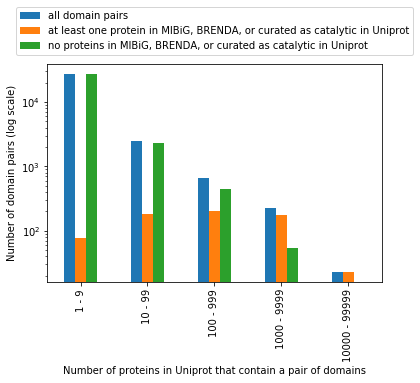

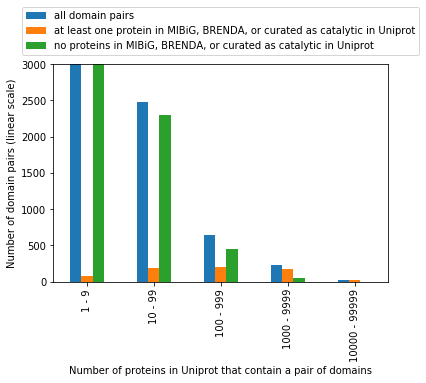

In [22]:
%matplotlib inline

print("{} total domains analyzed; all possible combinations would make {} pairs".format(num_domains,total_combinations))

domain_pairs_to_uniprot_frozensets_dict=all_of_uniprot_domainoccurrences.domain_pair_frozenset_to_protein_list_dict
number_of_pairs_dict={k:len(v) for k,v in domain_pairs_to_uniprot_frozensets_dict.items()}

pairs_in_mibig_or_uniprotcatalytic_or_brenda={k:(uniprot_curated_catalytic_domainoccurrences.get_domain_pair_protein_tally(k)>0) or
                                              (mibig_domainoccurrences.get_domain_pair_protein_tally(k)>0) or
                                              (brenda_domainoccurrences.get_domain_pair_protein_tally(k)>0) for k in
                                              domain_pairs_to_uniprot_frozensets_dict.keys()}

number_of_pairs_df=pandas.DataFrame({"number_of_pairs":number_of_pairs_dict,"domain_pair_in_mibig_or_uniprotcatalytic_or_brenda":pairs_in_mibig_or_uniprotcatalytic_or_brenda})
number_of_unannotated_pairs_df=number_of_pairs_df[~number_of_pairs_df["domain_pair_in_mibig_or_uniprotcatalytic_or_brenda"]]

order_of_magnitude_index=pandas.IntervalIndex.from_breaks([1,10,100,1000,10000,100000],closed='left')
number_of_pairs_binned_by_order_of_magnitude=pandas.cut(number_of_pairs_df["number_of_pairs"],order_of_magnitude_index)
number_of_annotated_pairs_binned_by_order_of_magnitude=pandas.cut(number_of_pairs_df[number_of_pairs_df["domain_pair_in_mibig_or_uniprotcatalytic_or_brenda"]]["number_of_pairs"],order_of_magnitude_index)
number_of_unannotated_pairs_binned_by_order_of_magnitude=pandas.cut(number_of_unannotated_pairs_df["number_of_pairs"],order_of_magnitude_index)

plotting_df=pandas.DataFrame({"all domain pairs":number_of_pairs_binned_by_order_of_magnitude.value_counts(),"at least one protein in MIBiG, BRENDA, or curated as catalytic in Uniprot":number_of_annotated_pairs_binned_by_order_of_magnitude.value_counts(),"no proteins in MIBiG, BRENDA, or curated as catalytic in Uniprot":number_of_unannotated_pairs_binned_by_order_of_magnitude.value_counts()})

log_ax=plotting_df.plot(kind='bar',logy=True)
log_ax.set_ylabel("Number of domain pairs (log scale)")

linear_ax=plotting_df.plot(kind='bar',ylim=[0,3000])
linear_ax.set_ylabel("Number of domain pairs (linear scale)")

for ax in (log_ax,linear_ax):
    ax.set_xlabel("Number of proteins in Uniprot that contain a pair of domains")
    ax.set_xticklabels(["{} - {}".format(i.left,i.right-1) for i in order_of_magnitude_index])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02))

for number in [1,10,100,1000,10000]:
    total=len(number_of_pairs_df[number_of_pairs_df["number_of_pairs"]>=number])
    unannotated=len(number_of_unannotated_pairs_df[number_of_unannotated_pairs_df["number_of_pairs"]>=number])
    print("For the {} domain pairs with at least {} proteins in Uniprot, {} ({:.2f}%) are unannotated (i.e., do not have any entries in MIBiG, BRENDA, or curated as catalytic in Uniprot)".format(total,number,unannotated,100.0*unannotated/total))
    
    
#these results do not change substantially when I include the "u" category in the analysis